In [1]:
import mne
from scipy.io import loadmat
import scipy
import sklearn
import numpy as np
import pandas as pd
import glob
from mne.decoding import CSP
import os
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

In [3]:
import warnings
warnings.filterwarnings('ignore') # to ignore warnings

In [4]:
verbose = False                    # global variable to suppress output display of MNE functions
mne.set_log_level(verbose=verbose) # to suppress large info outputs

In [5]:
# using kappa as evaluation metric
kappa = sklearn.metrics.make_scorer(sklearn.metrics.cohen_kappa_score) # kappa scorer
acc = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)      # accuracy scorer
scorer = kappa         # just assign another scorer to replace kappa scorer

In [6]:
current_folder = globals()['_dh'][0]  # a hack to get path of current folder in which juptyter file is located
data_path = os.path.join(current_folder, 'Data')

In [7]:
training_files   = glob.glob(data_path + '/*T.mat')
len(training_files)     # if  return zero,then no file is loaded

8

In [8]:
def get_mne_epochs(filepath, verbose=verbose, t_start=2, fs=512, mode='train'):
    '''
    This function reads the EEG data from .mat file and convert it to MNE-Python Compatible epochs
    data structure. It takes data from [0, 8] sec range and return it by setting t = 0 at cue onset
    i.e. 3 seconds and dropping first two seconds so the output data is in [-1.0, 5.0] sec range. The
    Details can be found in the preprocessing section of the attached document
    '''
    mat_data = loadmat(filepath) # read .mat file
    eeg_data= mat_data['RawEEGData']
    idx_start = fs*t_start      
    eeg_data = eeg_data[:, :, idx_start:]
    event_id = {'left-hand': 1, 'right-hand': 2}
    channel_names = ['F3', 'FC3', 'C3', 'CP3', 'P3', 'FCz', 'CPz', 'F4', 'FC4', 'C4', 'CP4', 'P4']
    info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types='eeg')
    epochs = mne.EpochsArray(eeg_data, info, verbose=verbose, tmin=t_start-3.0)
    epochs.set_montage('standard_1020')
    epochs.filter(1., None) 
    epochs.apply_baseline(baseline=(-.250, 0)) # linear baseline correction
    
    if mode == 'train': # this in only applicable for training data
        epochs.event_id = event_id
        epochs.events[:,2] = mat_data['Labels'].ravel()    
    return epochs 

def get_labels(filepath):
    mat_data = loadmat(filepath) # read .mat file
    return mat_data['Labels'].ravel()

In [32]:
epochs, labels = get_mne_epochs(training_files[0], verbose=verbose), get_labels(training_files[3])
data= epochs.get_data()
print('Shape of EEG Data: ', data.shape, '\T Shape of Labels: ', labels.shape)

Shape of EEG Data:  (80, 12, 3072) \T Shape of Labels:  (80,)


In [34]:
main_data=epochs.to_data_frame()
main_data

,time,condition,epoch,F3,FC3,C3,CP3,P3,FCz,CPz,F4,FC4,C4,CP4,P4
0,-1000,left-hand,0,-3.129383e+07,-3.006802e+07,-2.665316e+07,-4.170347e+07,-4.429883e+07,-3.858507e+07,-4.126349e+07,-4.458233e+07,-3.473291e+07,-3.921564e+07,-3.826042e+07,-2.208606e+07
1,-998,left-hand,0,8.777848e+07,7.799296e+07,8.495140e+07,8.524078e+07,9.546214e+07,8.267357e+07,9.153914e+07,7.738731e+07,8.390504e+07,8.983827e+07,8.079101e+07,7.796770e+07
2,-996,left-hand,0,1.349900e+08,1.260914e+08,1.197416e+08,1.560168e+08,1.682784e+08,1.490005e+08,1.593179e+08,1.621780e+08,1.399895e+08,1.663058e+08,1.495160e+08,1.114601e+08
3,-994,left-hand,0,6.095198e+07,6.599956e+07,4.968692e+07,9.521649e+07,9.708323e+07,8.949994e+07,9.187406e+07,1.178016e+08,7.136090e+07,1.046980e+08,9.782751e+07,4.721878e+07
4,-992,left-hand,0,-5.006314e+07,-3.257786e+07,-4.204703e+07,-2.565440e+07,-3.141970e+07,-2.494216e+07,-2.872093e+07,-2.162746e+06,-3.630057e+07,-2.825119e+07,-1.408204e+07,-3.970100e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245755,4990,left-hand,79,1.961046e+07,2.851510e+07,2.500605e+07,4.071888e+07,4.563501e+07,4.398372e+07,4.554487e+07,5.052772e+07,3.248992e+07,5.044809e+07,3.984921e+07,3.921758e+07
245756,4992,left-hand,79,-5.873368e+07,-4.699634e+07,-5.053439e+07,-4.676613e+07,-4.524229e+07,-4.034750e+07,-4.261512e+07,-3.670792e+07,-4.686057e+07,-3.462716e+07,-3.921965e+07,-4.305324e+07
245757,4994,left-hand,79,-1.144586e+08,-1.063857e+08,-1.025890e+08,-1.175036e+08,-1.213888e+08,-1.131419e+08,-1.171400e+08,-1.176467e+08,-1.153728e+08,-1.157137e+08,-1.070569e+08,-1.051850e+08
245758,4996,left-hand,79,-6.333326e+07,-6.107951e+07,-5.432756e+07,-7.185416e+07,-7.682529e+07,-7.217363e+07,-7.402730e+07,-7.985564e+07,-7.406931e+07,-8.037643e+07,-6.838605e+07,-6.375340e+07


In [ ]:
## Feature Engineering

# def mean(x, y, z):
#     """Calculates mean"""
#     mean_x = np.mean(x)
#     mean_y = np.mean(y)
#     mean_z = np.mean(z)
#     return mean_x, mean_y, mean_z

# def std_dev(x, y, z):
#     """Calculates standard deviation"""
#     std_x = np.std(x)
#     std_y = np.std(y)
#     std_z = np.std(z)
#     return std_x, std_y, std_z  
    
# def mad(x, y, z):
#     """Calculates median absolute deviation"""
#     mad_x = np.median(np.abs(x - np.median(x)))
#     mad_y = np.median(np.abs(y - np.median(y)))
#     mad_z = np.median(np.abs(z - np.median(z)))
#     return mad_x, mad_y, mad_z

# def minimum(x, y, z):
#     """Calculates minimum"""
#     return min(x), min(y), min(z)

# def maximum(x, y, z):
#     """Calculates maximum"""
#     return max(x), max(y), max(z)

# def energy_measure(x, y, z):
#     """Calculates energy measures"""
#     em_x = np.mean(np.square(x))
#     em_y = np.mean(np.square(y))
#     em_z = np.mean(np.square(z))
#     return em_x, em_y, em_z

# def inter_quartile_range(x, y, z):
#     """Calculates inter-quartile range"""
#     iqr_x = np.subtract(*np.percentile(x, [75, 25]))
#     iqr_y = np.subtract(*np.percentile(y, [75, 25]))
#     iqr_z = np.subtract(*np.percentile(z, [75, 25]))
#     return iqr_x, iqr_y, iqr_z

# # def sma(x, y, z):
# #     """Calculates signal magnitude area"""   
# #     abs_x = np.absolute(x)
# #     abs_y = np.absolute(y)
# #     abs_z = np.absolute(z)
# #     return np.mean(abs_x+abs_y+abs_z)

# def skewness(x, y, z):
#     """Calculates skewness"""
#     skew_x=stats.skew(x)
#     skew_y=stats.skew(y)
#     skew_z=stats.skew(z)
#     return skew_x, skew_y, skew_z

# def kurt(x, y, z):
#     """Calculates kurtosis"""
#     kurt_x = stats.kurtosis(x,fisher=False)
#     kurt_y = stats.kurtosis(y,fisher=False)
#     kurt_z = stats.kurtosis(z,fisher=False)
#     return kurt_x, kurt_y, kurt_z

In [ ]:
main_data['roll_mean_F3'],main_data['roll_mean_FC3'], main_data['roll_mean_C3']=rolling_mean(main_data['F3'],main_data['FC3'],main_data['C3'])
main_data['roll_std_F3'],main_data['roll_std_FC3'], main_data['roll_std_C3']=rolling_std(main_data['F3'],main_data['FC3'],main_data['C3'])
main_data['roll_min_F3'],main_data['roll_min_FC3'], main_data['roll_min_C3']=rolling_min(main_data['F3'],main_data['FC3'],main_data['C3'])
main_data['roll_max_F3'],main_data['roll_max_FC3'], main_data['roll_max_C3']=rolling_max(main_data['F3'],main_data['FC3'],main_data['C3'])
main_data['roll_EME_F3'],main_data['roll_EME_FC3'], main_data['roll_EME_C3']=rolling_energy_measure(main_data['F3'],main_data['FC3'],main_data['C3'])
main_data['roll_IQR_F3'],main_data['roll_IQR_FC3'], main_data['roll_IQR_C3']=rolling_IQ_Range(main_data['F3'],main_data['FC3'],main_data['C3'])
# main_data['Acc-SMA']=sma(main_data['Acc_x'],main_data['Acc_y'],main_data['Acc_z'])
main_data['roll_skew_F3'],main_data['roll_skew_FC3'], main_data['roll_skew_C3']=rolling_skew(main_data['F3'],main_data['FC3'],main_data['C3'])

main_data['roll_mean_CP3'],main_data['roll_mean_P3'], main_data['roll_mean_FCz']=rolling_mean(main_data['CP3'],main_data['P3'],main_data ['FCz'])
main_data['roll_std_CP3'],main_data['roll_std_P3'], main_data['roll_std_FCz']=rolling_std(main_data['CP3'],main_data['P3'],main_data ['FCz'])
main_data['roll_mad_CP3'],main_data['roll_mad_P3'], main_data['roll_mad_FCz']=rolling_mad(main_data['CP3'],main_data['P3'],main_data ['FCz'])
main_data['roll_min_CP3'],main_data['roll_P3'], main_data['roll_min_FCz']=rolling_min(main_data['CP3'],main_data['P3'],main_data ['FCz'])
main_data['roll_max_CP3'],main_data['roll_max_P3'], main_data['roll_max_FCz']=rolling_max(main_data['CP3'],main_data['P3'],main_data ['FCz'])
main_data['roll_EME_CP3'],main_data['roll_EME_P3'], main_data['roll_EME_FCz']=rolling_energy_measure(main_data['CP3'],main_data['P3'],main_data ['FCz'])
main_data['roll_IQR_CP3'],main_data['roll_IQR_P3'], main_data['roll_IQR_FCz']=rolling_IQ_Range(main_data['CP3'],main_data['P3'],main_data ['FCz'])
# main_data['N-Gyro-SMA']=sma(main_data['Gyro_x'],main_data['Gyro_y'],main_data['Gyro_z'])
main_data['roll_skew_CP3'],main_data['roll_skew_P3'], main_data['roll_skew_FCz']=rolling_skew(main_data['CP3'],main_data['P3'],main_data ['FCz'])

main_data['roll_mean_CPz'],main_data['roll_mean_F4'], main_data['roll_mean_FC4']=rolling_mean(main_data['CPz'],main_data['F4'],main_data['FC4'])
main_data['roll_std_CPz'],main_data['roll_std_F4'], main_data['roll_std_FC4']=rolling_std(main_data['CPz'],main_data['F4'],main_data['FC4'])
main_data['roll_mad_CPz'],main_data['roll_mad_F4'], main_data['roll_mad_FC4']=rolling_mad(main_data['CPz'],main_data['F4'],main_data['FC4'])
main_data['roll_min_CPz'],main_data['roll_min_F4'], main_data['roll_min_FC4']=rolling_min(main_data['CPz'],main_data['F4'],main_data['FC4'])
main_data['roll_max_CPz'],main_data['roll_max_F4'], main_data['roll_max_FC4']=rolling_max(main_data['CPz'],main_data['F4'],main_data['FC4'])
main_data['roll_EME_CPz'],main_data['roll_EME_F4'], main_data['roll_EME_FC4']=rolling_energy_measure(main_data['CPz'],main_data['F4'],main_data['FC4'])
main_data['roll_IQR_CPz'],main_data['roll_IQR_F4'], main_data['roll_IQR_FC4']=rolling_IQ_Range(main_data['CPz'],main_data['F4'],main_data['FC4'])
# main_data['T-Acc-SMA']=sma(main_data['Mag_x'],main_data['Mag_yFC4n_data['Mag_z'])
main_data['roll_skew_CPz'],main_data['roll_skew_F4'], main_data['roll_skew_FC4']=rolling_skew(main_data['CPz'],main_data['F4'],main_data['FC4'])

main_data['roll_mean_C4'],main_data['roll_mean_CP4'], main_data['roll_mean_P4']=rolling_mean(main_data['C4'],main_data['CP4'],main_data['P4'])
main_data['roll_std_C4'],main_data['roll_std_CP4'], main_data['roll_std_P4']=rolling_std(main_data['C4'],main_data['CP4'],main_data['P4'])
main_data['roll_mad_C4'],main_data['roll_mad_CP4'], main_data['roll_mad_P4']=rolling_mad(main_data['C4'],main_data['CP4'],main_data['P4'])
main_data['roll_min_C4'],main_data['roll_min_CP4'], main_data['roll_min_P4']=rolling_min(main_data['C4'],main_data['CP4'],main_data['P4'])
main_data['roll_max_C4'],main_data['roll_max_CP4'], main_data['roll_max_P4']=rolling_max(main_data['C4'],main_data['CP4'],main_data['P4'])
main_data['roll_EME_C4'],main_data['roll_EME_CP4'], main_data['roll_EME_P4']=rolling_energy_measure(main_data['C4'],main_data['CP4'],main_data['P4'])
main_data['roll_IQR_C4'],main_data['roll_IQR_CP4'], main_data['roll_IQR_P4']=rolling_IQ_Range(main_data['C4'],main_data['CP4'],main_data['P4'])
# main_data['T-Acc-SMA']=sma(main_data['Mag_x'],main_data['Mag_y'],main_data['Mag_z'])CP4main_data['roll_skew_TAccX'],main_data['roll_skew_C
main_data['roll_skew_C4'],main_data['roll_skew_CP4'], main_data['roll_skew_P4']=rolling_skew(main_data['C4'],main_data['CP4'],main_data['P4'])

In [ ]:
X = main_data[['F3', 'FC3', 'C3', 'CP3', 'P3',
       'FCz', 'CPz', 'F4', 'FC4', 'C4', 'CP4', 'P4', 'roll_mean_F3',
       'roll_mean_FC3', 'roll_mean_C3', 'roll_std_F3', 'roll_std_FC3',
       'roll_std_C3', 'roll_min_F3', 'roll_min_FC3', 'roll_min_C3',
       'roll_max_F3', 'roll_max_FC3', 'roll_max_C3', 'roll_EME_F3',
       'roll_EME_FC3', 'roll_EME_C3', 'roll_IQR_F3', 'roll_IQR_FC3',
       'roll_IQR_C3', 'roll_skew_F3', 'roll_skew_FC3', 'roll_skew_C3',
       'roll_mean_CP3', 'roll_mean_P3', 'roll_mean_FCz', 'roll_std_CP3',
       'roll_std_P3', 'roll_std_FCz', 'roll_mad_CP3', 'roll_mad_P3',
       'roll_mad_FCz', 'roll_min_CP3', 'roll_P3', 'roll_min_FCz',
       'roll_max_CP3', 'roll_max_P3', 'roll_max_FCz', 'roll_EME_CP3',
       'roll_EME_P3', 'roll_EME_FCz', 'roll_IQR_CP3', 'roll_IQR_P3',
       'roll_IQR_FCz', 'roll_skew_CP3', 'roll_skew_P3', 'roll_skew_FCz',
       'roll_mean_CPz', 'roll_mean_F4', 'roll_mean_FC4', 'roll_std_CPz',
       'roll_std_F4', 'roll_std_FC4', 'roll_mad_CPz', 'roll_mad_F4',
       'roll_mad_FC4', 'roll_min_CPz', 'roll_min_F4', 'roll_min_FC4',
       'roll_max_CPz', 'roll_max_F4', 'roll_max_FC4', 'roll_EME_CPz',
       'roll_EME_F4', 'roll_EME_FC4', 'roll_IQR_CPz', 'roll_IQR_F4',
       'roll_IQR_FC4', 'roll_skew_CPz', 'roll_skew_F4', 'roll_skew_FC4',
       'roll_mean_C4', 'roll_mean_CP4', 'roll_mean_P4', 'roll_std_C4',
       'roll_std_CP4', 'roll_std_P4', 'roll_mad_C4', 'roll_mad_CP4',
       'roll_mad_P4', 'roll_min_C4', 'roll_min_CP4', 'roll_min_P4',
       'roll_max_C4', 'roll_max_CP4', 'roll_max_P4', 'roll_EME_C4',
       'roll_EME_CP4', 'roll_EME_P4', 'roll_IQR_C4', 'roll_IQR_CP4',
       'roll_IQR_P4', 'roll_skew_C4', 'roll_skew_CP4', 'roll_skew_P4']]

y = main_data['condition']

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_data = pd.DataFrame(data = X, columns =[[ 'F3', 'FC3', 'C3', 'CP3', 'P3',
       'FCz', 'CPz', 'F4', 'FC4', 'C4', 'CP4', 'P4', 'roll_mean_F3',
       'roll_mean_FC3', 'roll_mean_C3', 'roll_std_F3', 'roll_std_FC3',
       'roll_std_C3', 'roll_min_F3', 'roll_min_FC3', 'roll_min_C3',
       'roll_max_F3', 'roll_max_FC3', 'roll_max_C3', 'roll_EME_F3',
       'roll_EME_FC3', 'roll_EME_C3', 'roll_IQR_F3', 'roll_IQR_FC3',
       'roll_IQR_C3', 'roll_skew_F3', 'roll_skew_FC3', 'roll_skew_C3',
       'roll_mean_CP3', 'roll_mean_P3', 'roll_mean_FCz', 'roll_std_CP3',
       'roll_std_P3', 'roll_std_FCz', 'roll_mad_CP3', 'roll_mad_P3',
       'roll_mad_FCz', 'roll_min_CP3', 'roll_P3', 'roll_min_FCz',
       'roll_max_CP3', 'roll_max_P3', 'roll_max_FCz', 'roll_EME_CP3',
       'roll_EME_P3', 'roll_EME_FCz', 'roll_IQR_CP3', 'roll_IQR_P3',
       'roll_IQR_FCz', 'roll_skew_CP3', 'roll_skew_P3', 'roll_skew_FCz',
       'roll_mean_CPz', 'roll_mean_F4', 'roll_mean_FC4', 'roll_std_CPz',
       'roll_std_F4', 'roll_std_FC4', 'roll_mad_CPz', 'roll_mad_F4',
       'roll_mad_FC4', 'roll_min_CPz', 'roll_min_F4', 'roll_min_FC4',
       'roll_max_CPz', 'roll_max_F4', 'roll_max_FC4', 'roll_EME_CPz',
       'roll_EME_F4', 'roll_EME_FC4', 'roll_IQR_CPz', 'roll_IQR_F4',
       'roll_IQR_FC4', 'roll_skew_CPz', 'roll_skew_F4', 'roll_skew_FC4',
       'roll_mean_C4', 'roll_mean_CP4', 'roll_mean_P4', 'roll_std_C4',
       'roll_std_CP4', 'roll_std_P4', 'roll_mad_C4', 'roll_mad_CP4',
       'roll_mad_P4', 'roll_min_C4', 'roll_min_CP4', 'roll_min_P4',
       'roll_max_C4', 'roll_max_CP4', 'roll_max_P4', 'roll_EME_C4',
       'roll_EME_CP4', 'roll_EME_P4', 'roll_IQR_C4', 'roll_IQR_CP4',
       'roll_IQR_P4', 'roll_skew_C4', 'roll_skew_CP4', 'roll_skew_P4']])

scaled_data['condition'] = y.values
                           
scaled_data.head()

In [ ]:
scaled_data.to_csv('Whole_dataset_with_feature_1.csv',index=False) 

In [21]:
df= pd.read_csv('E:/Desktop/machine learning/Whole_dataset_with_feature_1.csv')

In [11]:
df

,F3,FC3,C3,CP3,P3,FCz,CPz,F4,FC4,C4,...,roll_EME_C4,roll_EME_CP4,roll_EME_P4,roll_IQR_C4,roll_IQR_CP4,roll_IQR_P4,roll_skew_C4,roll_skew_CP4,roll_skew_P4,condition
0,-0.483741,-0.489645,-0.447421,-0.586203,-0.589802,-0.552723,-0.566629,-0.614639,-0.493795,-0.527337,...,-2.944891,-3.545392,-2.226300,-6.851300,-8.159691,-5.673517,-12.794549,-13.476516,-11.136195,0
1,1.334443,1.254961,1.411925,1.177029,1.250426,1.165025,1.239182,1.048131,1.175278,1.187221,...,-2.057714,-2.397375,-1.535880,-6.851300,-8.159691,-5.673517,8.510309,8.332993,9.389266,0
2,2.055344,2.031493,1.991534,2.160095,2.209196,2.104612,2.160819,2.204053,1.964309,2.203138,...,0.982488,1.534482,-0.124894,-1.678317,-1.849399,-1.206963,5.118926,5.172960,3.440845,0
3,0.924814,1.061332,0.824414,1.315590,1.271771,1.261728,1.243737,1.599085,0.998799,1.384641,...,2.187424,3.217715,0.128335,-0.822679,-0.518740,-1.206963,-0.926574,-1.346622,0.188669,0
4,-0.770340,-0.530166,-0.703885,-0.363285,-0.420223,-0.359458,-0.396079,-0.036348,-0.515849,-0.381667,...,2.275157,3.252594,0.307349,0.804055,0.581157,0.058287,-0.693002,-1.037972,-0.525689,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245755,0.293546,0.456159,0.413228,0.558628,0.594354,0.616945,0.613766,0.681963,0.451938,0.663899,...,1.067350,1.884162,-0.015644,-0.463625,0.463821,-0.179573,0.262798,0.289809,-0.296703,0
245756,-0.902736,-0.762947,-0.845286,-0.656523,-0.602225,-0.577690,-0.585008,-0.507290,-0.664414,-0.466376,...,0.570276,1.024700,-0.170050,-0.463625,-0.583558,-0.960449,-2.469823,-2.750154,-1.179089,0
245757,-1.753631,-1.721767,-1.712522,-1.639054,-1.604843,-1.608894,-1.598376,-1.610700,-1.628287,-1.543658,...,-0.432346,-0.292697,-0.240487,-0.463625,-0.583558,-0.960449,-0.123548,-0.106744,-0.939216,0
245758,-0.972969,-0.990315,-0.908480,-1.004991,-1.018077,-1.028539,-1.012142,-1.095508,-1.047204,-1.074182,...,-0.408376,-0.253692,0.028584,-0.384843,-0.455374,0.225406,-0.080410,-0.022397,0.396305,0


In [12]:
df['condition'].value_counts()

0    122880
1    122880
Name: condition, dtype: int64

In [13]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix

# Randomization
import random

In [14]:
df['condition'].value_counts()

0    122880
1    122880
Name: condition, dtype: int64

In [15]:
# df['condition'].replace({'right-hand': 1,'left-hand': 0},inplace=True)

In [16]:
X= df.drop(['condition'], axis=1)
y = df['condition']

In [17]:
X

,F3,FC3,C3,CP3,P3,FCz,CPz,F4,FC4,C4,...,roll_max_P4,roll_EME_C4,roll_EME_CP4,roll_EME_P4,roll_IQR_C4,roll_IQR_CP4,roll_IQR_P4,roll_skew_C4,roll_skew_CP4,roll_skew_P4
0,-0.483741,-0.489645,-0.447421,-0.586203,-0.589802,-0.552723,-0.566629,-0.614639,-0.493795,-0.527337,...,-4.256338,-2.944891,-3.545392,-2.226300,-6.851300,-8.159691,-5.673517,-12.794549,-13.476516,-11.136195
1,1.334443,1.254961,1.411925,1.177029,1.250426,1.165025,1.239182,1.048131,1.175278,1.187221,...,-0.192414,-2.057714,-2.397375,-1.535880,-6.851300,-8.159691,-5.673517,8.510309,8.332993,9.389266
2,2.055344,2.031493,1.991534,2.160095,2.209196,2.104612,2.160819,2.204053,1.964309,2.203138,...,1.553314,0.982488,1.534482,-0.124894,-1.678317,-1.849399,-1.206963,5.118926,5.172960,3.440845
3,0.924814,1.061332,0.824414,1.315590,1.271771,1.261728,1.243737,1.599085,0.998799,1.384641,...,1.553314,2.187424,3.217715,0.128335,-0.822679,-0.518740,-1.206963,-0.926574,-1.346622,0.188669
4,-0.770340,-0.530166,-0.703885,-0.363285,-0.420223,-0.359458,-0.396079,-0.036348,-0.515849,-0.381667,...,1.553314,2.275157,3.252594,0.307349,0.804055,0.581157,0.058287,-0.693002,-1.037972,-0.525689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245755,0.293546,0.456159,0.413228,0.558628,0.594354,0.616945,0.613766,0.681963,0.451938,0.663899,...,-2.031789,1.067350,1.884162,-0.015644,-0.463625,0.463821,-0.179573,0.262798,0.289809,-0.296703
245756,-0.902736,-0.762947,-0.845286,-0.656523,-0.602225,-0.577690,-0.585008,-0.507290,-0.664414,-0.466376,...,-2.031789,0.570276,1.024700,-0.170050,-0.463625,-0.583558,-0.960449,-2.469823,-2.750154,-1.179089
245757,-1.753631,-1.721767,-1.712522,-1.639054,-1.604843,-1.608894,-1.598376,-1.610700,-1.628287,-1.543658,...,-2.031789,-0.432346,-0.292697,-0.240487,-0.463625,-0.583558,-0.960449,-0.123548,-0.106744,-0.939216
245758,-0.972969,-0.990315,-0.908480,-1.004991,-1.018077,-1.028539,-1.012142,-1.095508,-1.047204,-1.074182,...,-2.031789,-0.408376,-0.253692,0.028584,-0.384843,-0.455374,0.225406,-0.080410,-0.022397,0.396305


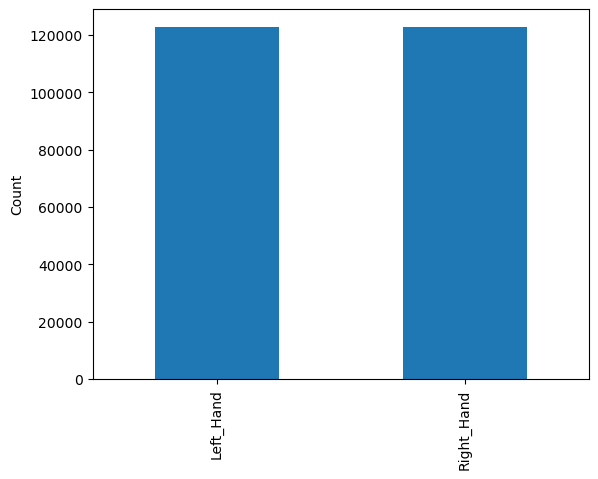

In [18]:
y.value_counts().plot(kind='bar')
plt.xticks([0,1], ['Left_Hand', 'Right_Hand'])
plt.ylabel('Count');

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## ICA

In [20]:
import matplotlib.pyplot as plt
from collections import deque
from sklearn.decomposition import FastICA

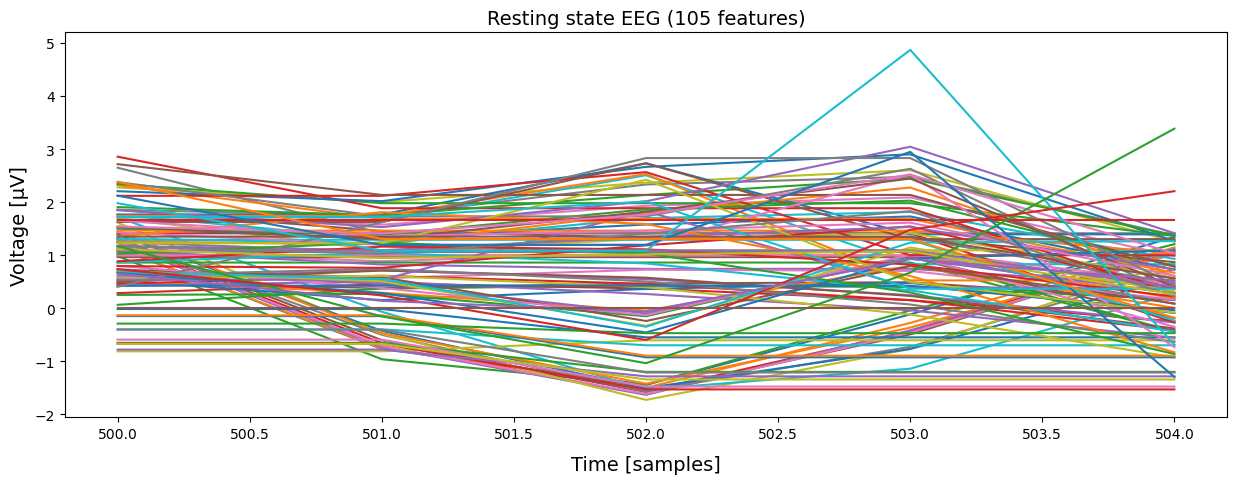

In [21]:
df.iloc[500:505].plot(figsize=(15,5), legend=False)
plt.xlabel('Time [samples]', fontsize=14, labelpad=10)
plt.ylabel('Voltage [\u03BCV]', fontsize=14)
plt.title('Resting state EEG (105 features)', fontsize=14)
#plt.savefig('eeg_all.png')
plt.show()

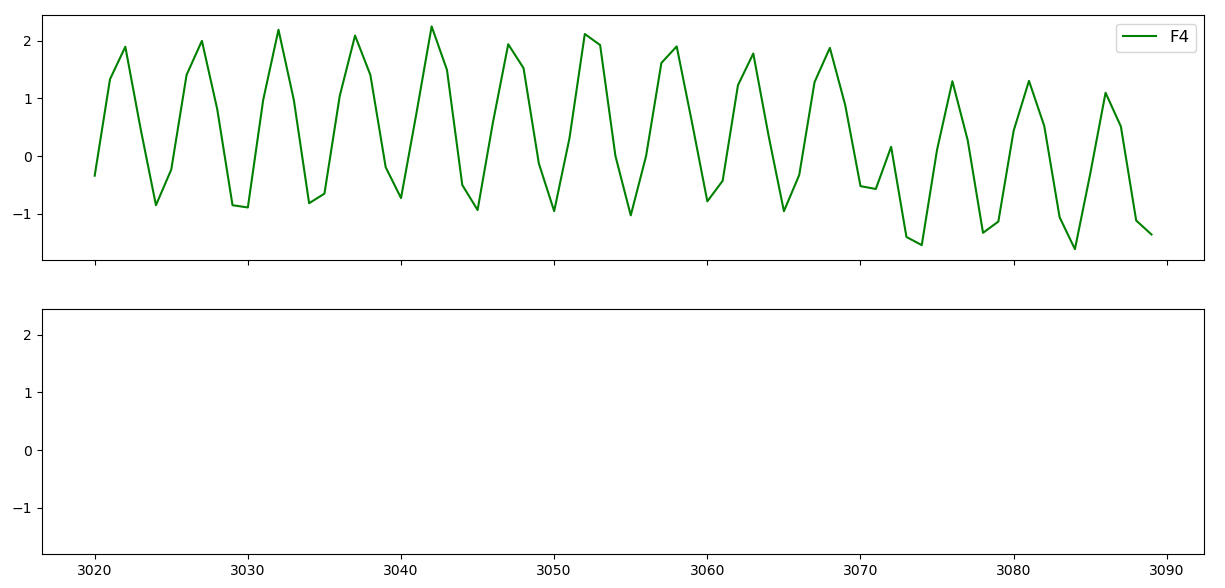

In [22]:
fig, axs = plt.subplots(2,1, figsize=(15, 7), sharex=True, sharey=True)
# axs = axs.ravel()
plt.margins(x=0.001)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axs[0].plot(df['F4'].iloc[3020:3090], label='F4', color='green')
axs[0].legend(loc="upper right", fontsize=12)
plt.show()

In [23]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=105, random_state=0)
X_ica = ica.fit_transform(X)

In [24]:
X = X_ica[:,:]
    
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# scaler = StandardScaler()
# X= scaler.fit_transform(X)
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))                        
# X_ica = scaler.fit_transform(Final_selected)

In [39]:
# scaled_data = pd.DataFrame(data = X, columns =[['F3', 'FC3', 'C3', 'CP3', 'P3', 'FCz', 'CPz', 'F4', 'FC4', 'C4', 'CP4', 'P4']])

# scaled_data['condition'] = y.values
                           
# scaled_data
# X_ica

array([[0.47500408, 0.66030706, 0.53228106, ..., 0.45823658, 0.35255615,
        0.64190199],
       [0.48950221, 0.63644581, 0.5599496 , ..., 0.48793723, 0.41726597,
        0.64978378],
       [0.48963797, 0.68105319, 0.50356818, ..., 0.4852024 , 0.29765122,
        0.65807425],
       ...,
       [0.49657229, 0.67515273, 0.55125947, ..., 0.47567451, 0.28255599,
        0.6611531 ],
       [0.49128917, 0.66660079, 0.55535618, ..., 0.48534915, 0.27549218,
        0.66194576],
       [0.4894502 , 0.62229967, 0.58169276, ..., 0.48501367, 0.25767051,
        0.66337394]])

In [40]:
# df=scaled_data

In [41]:
# import scipy.stats as stats

# frame_size = 4
# hop_size = 13

In [42]:
# def get_frames(df, frame_size, hop_size):

#     N_FEATURES = 12

#     frames = []
#     labels = []
#     for i in range(0, len(df) - frame_size, hop_size):
#         F3 = df['F3'].values[i: i + frame_size]
#         FC3 = df['FC3'].values[i: i + frame_size]
#         C3 = df['C3'].values[i: i + frame_size]
#         CP3 = df['CP3'].values[i: i + frame_size]
#         P3 = df['P3'].values[i: i + frame_size]
#         FCz = df['FCz'].values[i: i + frame_size]
#         CPz = df['CPz'].values[i: i + frame_size]
#         F4 = df['F4'].values[i: i + frame_size]
#         FC4 = df['FC4'].values[i: i + frame_size]
#         C4 = df['C4'].values[i: i + frame_size]
#         CP4 = df['CP4'].values[i: i + frame_size]
#         P4 = df['P4'].values[i: i + frame_size]
        
         
            
#         label = stats.mode(df['condition'][i: i + frame_size])[0][0]
#         frames.append([F3, FC3, C3, CP3, P3, FCz, CPz, F4, FC4, C4, CP4, P4])
#         labels.append(label)
        
        
#     frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
#     labels = np.asarray(labels)

#     return frames, labels

In [43]:
# X, y = get_frames(df, frame_size, hop_size)

In [25]:
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                          test_size=0.20,
#                                                          random_state=42)

In [44]:
X_test.shape

(61440, 75)

In [45]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
# knn.score(X_ica_test,y_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.66      0.71     30789
           1       0.70      0.80      0.75     30651

    accuracy                           0.73     61440
   macro avg       0.73      0.73      0.73     61440
weighted avg       0.73      0.73      0.73     61440



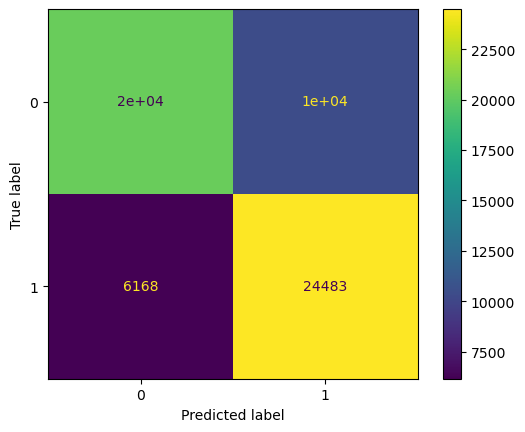

In [46]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [47]:
# from sklearn import svm
# clf = svm.SVC()
# clf.fit(X_ica_train, y_train)
# clf_pred = clf.predict(X_ica_test)
# # clf.score(X_test,y_test)
# print(classification_report(y_test, clf_pred))

In [48]:
# confusion_matrix = metrics.confusion_matrix(y_test, clf_pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

# cm_display.plot()
# plt.show()

In [49]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()       
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
# model.score(X_test,y_test)
print(classification_report(y_test,rfc_pred ))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80     30789
           1       0.79      0.81      0.80     30651

    accuracy                           0.80     61440
   macro avg       0.80      0.80      0.80     61440
weighted avg       0.80      0.80      0.80     61440



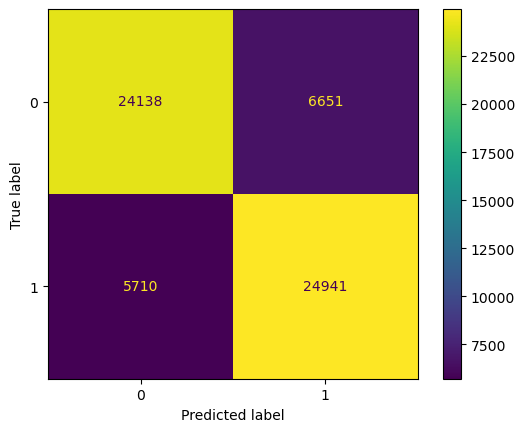

In [50]:
confusion_matrix = metrics.confusion_matrix(y_test, rfc_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)
GB_pred = GB.predict(X_test)
# GB.score(X_test,y_test)
print(classification_report(y_test,GB_pred))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     30789
           1       0.72      0.78      0.75     30651

    accuracy                           0.74     61440
   macro avg       0.74      0.74      0.74     61440
weighted avg       0.74      0.74      0.74     61440



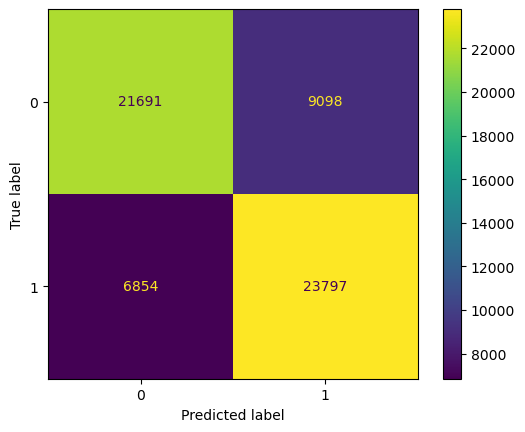

In [52]:
confusion_matrix = metrics.confusion_matrix(y_test, GB_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [53]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(X_test)
# XGB.score(X_test,y_test)
print(classification_report(y_test, XGB_pred))

              precision    recall  f1-score   support

           0       0.83      0.77      0.79     30789
           1       0.78      0.84      0.81     30651

    accuracy                           0.80     61440
   macro avg       0.80      0.80      0.80     61440
weighted avg       0.80      0.80      0.80     61440



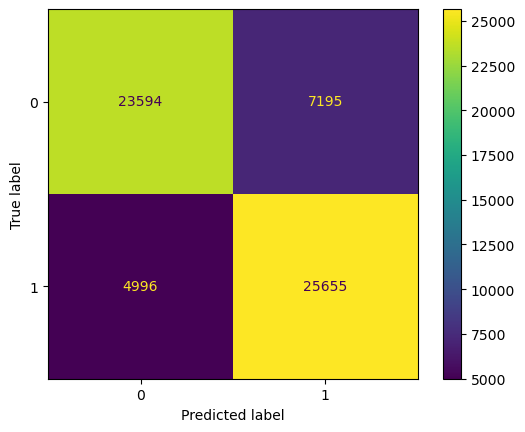

In [54]:
confusion_matrix = metrics.confusion_matrix(y_test, XGB_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [100]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(max_iter=1500)
MLP.fit(X_train, y_train)
prediction = MLP.predict(X_test)
# MLP.score(X_test,y_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     30789
           1       0.85      0.83      0.84     30651

    accuracy                           0.84     61440
   macro avg       0.84      0.84      0.84     61440
weighted avg       0.84      0.84      0.84     61440



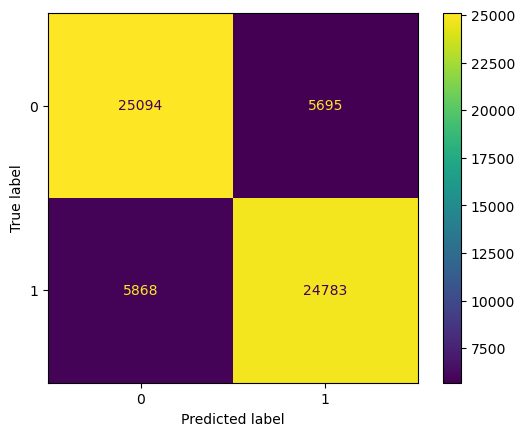

In [56]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.ensemble import AdaBoostClassifier

RFC = RandomForestClassifier()
XGB = XGBClassifier()
MLP = MLPClassifier(max_iter=500)


clf = VotingClassifier(estimators = [('rfc', RFC),('xbg', XGB), ('mlp', MLP)], voting='soft')

clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))
# print(accuracy_score(y_test, predictions))
# print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85     30789
           1       0.84      0.88      0.86     30651

    accuracy                           0.86     61440
   macro avg       0.86      0.86      0.86     61440
weighted avg       0.86      0.86      0.86     61440



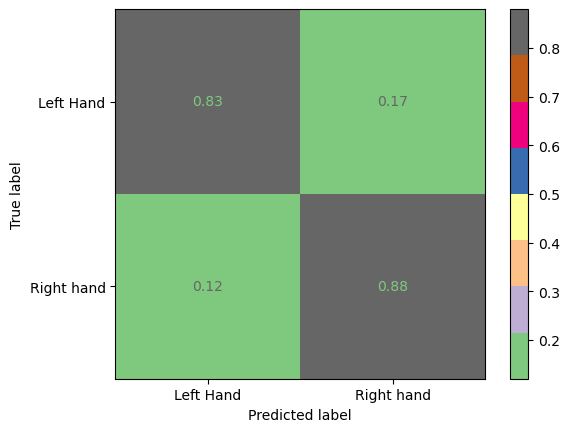

In [44]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Left Hand',
                                                          'Right hand'],
                     normalize='true', cmap='Accent');

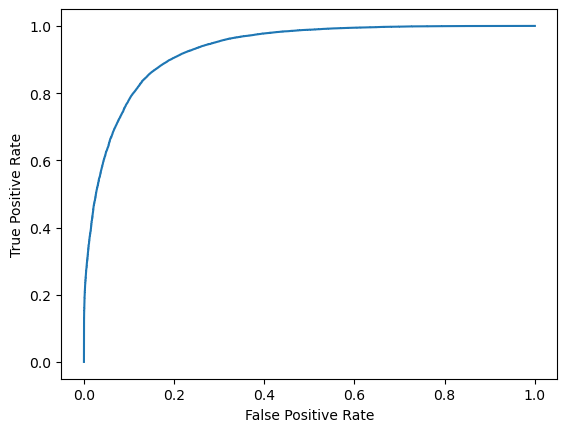

In [94]:
from sklearn import metrics
import matplotlib.pyplot as plt
y_pred_test = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)


#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()